# Multilayer Perceptron

## Import Pacakges

In [1]:
import tensorflow as tf
import torch
from torch import nn
from torch.utils import data
from torch.autograd import Variable

import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from mlxtend.plotting import plot_decision_regions

plt.rcParams["figure.figsize"] = (8, 8)

In [2]:
print(tf.__version__)

2.8.0


In [3]:
print(torch.__version__)

1.8.0


* https://www.tensorflow.org/tutorials/keras/classification
* https://www.tensorflow.org/tutorials/keras/text_classification
* https://towardsdatascience.com/how-to-train-a-classification-model-with-tensorflow-in-10-minutes-fd2b7cfba86
* https://www.kaggle.com/code/salehahmedrony/deep-learning-decision-boundary/notebook

## Problem - Classfication

### Global Variables

In [4]:
LEARNING_RATE = 0.03
NUM_EPOCHS = 20
BATCH_SIZE = 64
INIT_STDDEV = 0.01 # model weights - random initialisation from normal distribution
NUM_EXAMPLES = 200
BASE_COLORS = list(plt.cm.colors.BASE_COLORS.keys())

### Data Preparation

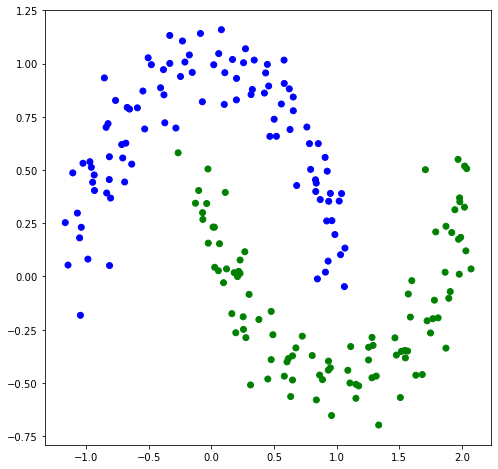

In [5]:
X, y = datasets.make_moons(n_samples=NUM_EXAMPLES, noise=.1, random_state=0)
plt.scatter(X[:,0], X[:, 1], color=[BASE_COLORS[int(i)] for i in y])

#### Tensorflow Data Prep

In [65]:
features, labels = tf.constant(X), tf.constant(y.astype(np.float))

/var/folders/sd/mz_l847n579df0n5l438fcl00000gr/T/ipykernel_3620/652541238.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  features, labels = tf.constant(X), tf.constant(y.astype(np.float))


In [66]:
features[:10], labels[:10]

(<tf.Tensor: shape=(10, 2), dtype=float64, numpy=
 array([[ 0.79235735,  0.50264857],
        [ 1.63158315, -0.4638967 ],
        [-0.06710927,  0.26776706],
        [-1.04412427, -0.18260761],
        [ 1.76704822, -0.19860987],
        [ 1.90607398, -0.07109159],
        [ 0.96219213,  0.26198607],
        [ 0.88681385, -0.48489624],
        [ 0.8689352 ,  0.36109278],
        [ 1.15352953, -0.57235293]])>,
 <tf.Tensor: shape=(10,), dtype=float64, numpy=array([0., 1., 1., 0., 1., 1., 0., 1., 0., 1.])>)

In [67]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """Construct a TensorFlow data iterator."""
    dataset = tf.data.Dataset.from_tensor_slices(data_arrays)
    if is_train:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    return dataset

In [68]:
data_iter = load_array((features, labels), BATCH_SIZE)

#### Pytorch Data Prep

In [78]:
features = torch.tensor(X)
labels = torch.tensor(y)

In [79]:
features[:10], labels[:10]

(tensor([[ 0.7924,  0.5026],
         [ 1.6316, -0.4639],
         [-0.0671,  0.2678],
         [-1.0441, -0.1826],
         [ 1.7670, -0.1986],
         [ 1.9061, -0.0711],
         [ 0.9622,  0.2620],
         [ 0.8868, -0.4849],
         [ 0.8689,  0.3611],
         [ 1.1535, -0.5724]], dtype=torch.float64),
 tensor([0, 1, 1, 0, 1, 1, 0, 1, 0, 1]))

In [80]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [81]:
data_iter = load_array((features, labels), BATCH_SIZE)

### Model Training

#### TF Keras Sequential API 

Need to rerun tensorflow data prep part!

**Defining Variables**

In [61]:
initializer = tf.initializers.RandomNormal(stddev=INIT_STDDEV)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE)
metrics=['accuracy']

**Logistic Regression**

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='sigmoid', input_dim=2,
                          kernel_initializer=initializer)
])

# # Alternatively
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.InputLayer(input_shape=(2, ))
# model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

In [32]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
model.fit(data_iter,
          epochs=NUM_EPOCHS)

Epoch 1/20
4/4 [==============================] - 0s 14ms/step - loss: 0.6880 - accuracy: 0.8400
Epoch 2/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6766 - accuracy: 0.8100
Epoch 3/20
4/4 [==============================] - 0s 5ms/step - loss: 0.6676 - accuracy: 0.8150
Epoch 4/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6577 - accuracy: 0.8150
Epoch 5/20
1/4 [======>.......................] - ETA: 0s - loss: 0.6466 - accuracy: 0.8594

2022-04-21 18:13:51.928527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 5ms/step - loss: 0.6483 - accuracy: 0.8100
Epoch 6/20
4/4 [==============================] - 0s 5ms/step - loss: 0.6383 - accuracy: 0.8100
Epoch 7/20
4/4 [==============================] - 0s 5ms/step - loss: 0.6301 - accuracy: 0.8150
Epoch 8/20
4/4 [==============================] - 0s 5ms/step - loss: 0.6211 - accuracy: 0.8150
Epoch 9/20
4/4 [==============================] - 0s 5ms/step - loss: 0.6129 - accuracy: 0.8150
Epoch 10/20
4/4 [==============================] - 0s 5ms/step - loss: 0.6058 - accuracy: 0.8150
Epoch 11/20
4/4 [==============================] - 0s 5ms/step - loss: 0.5992 - accuracy: 0.8150
Epoch 12/20
4/4 [==============================] - 0s 5ms/step - loss: 0.5919 - accuracy: 0.8100
Epoch 13/20
4/4 [==============================] - 0s 5ms/step - loss: 0.5847 - accuracy: 0.8100
Epoch 14/20
4/4 [==============================] - 0s 5ms/step - loss: 0.5774 - accuracy: 0.8100
Epoch 15/20
4/4 [=============================

2022-04-21 18:13:54.570646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<AxesSubplot:>

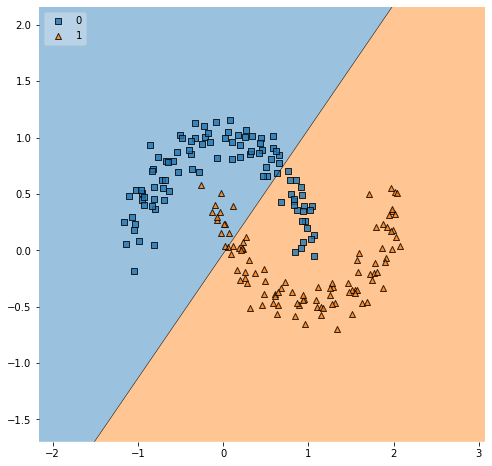

In [34]:
plot_decision_regions(X=X, y=y, clf=model, legend=2)

* The input layer can be ommited here and model can be fitted on input data at a later stage. This way however, `model.summary()` can only be called later when the input data shape is known to the object.
* Any types of feature preprocessing e.g. normalisation (`tf.keras.layers.Normalization`) can also be included in the sequential steps as the initial layer.

**MLP: Model Architecture** 

In [69]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_dim=2), # input shape is defined here
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [70]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 32)                96        
                                                                 
 dense_17 (Dense)            (None, 32)                1056      
                                                                 
 dense_18 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,185
Trainable params: 1,185
Non-trainable params: 0
_________________________________________________________________


* Here we can only call `model.summary()` if the object knows about the input shape

**MLP: Compile model then train**

In [71]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.05),
              loss=loss,
              metrics=metrics)
model.fit(data_iter,
          epochs=NUM_EPOCHS)

Epoch 1/20


2022-04-21 18:18:10.338890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 60ms/step - loss: 0.5690 - accuracy: 0.7300
Epoch 2/20
4/4 [==============================] - 0s 7ms/step - loss: 0.3144 - accuracy: 0.8750
Epoch 3/20
4/4 [==============================] - 0s 7ms/step - loss: 0.3724 - accuracy: 0.8800
Epoch 4/20
4/4 [==============================] - 0s 6ms/step - loss: 0.2592 - accuracy: 0.8800
Epoch 5/20
4/4 [==============================] - 0s 6ms/step - loss: 0.2697 - accuracy: 0.8700
Epoch 6/20
4/4 [==============================] - 0s 6ms/step - loss: 0.2244 - accuracy: 0.9100
Epoch 7/20
4/4 [==============================] - 0s 6ms/step - loss: 0.2067 - accuracy: 0.9100
Epoch 8/20
4/4 [==============================] - 0s 6ms/step - loss: 0.1972 - accuracy: 0.9250
Epoch 9/20
4/4 [==============================] - 0s 6ms/step - loss: 0.1743 - accuracy: 0.9200
Epoch 10/20
4/4 [==============================] - 0s 6ms/step - loss: 0.1454 - accuracy: 0.9400
Epoch 11/20
4/4 [==============================] 

**MLP: Decision Boundary**

2022-04-21 18:18:14.430210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<AxesSubplot:>

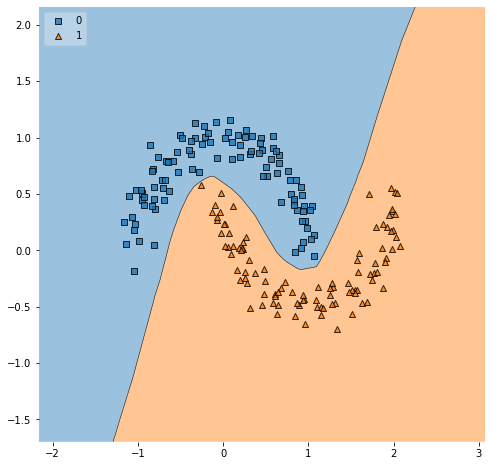

In [72]:
plot_decision_regions(X=X, y=y, clf=model, legend=2)

#### TF Keras Functional API

In [73]:
inputs = tf.keras.Input(shape=(2,))
h1 = tf.keras.layers.Dense(32, activation="relu")(inputs)
h2 = tf.keras.layers.Dense(32, activation="relu")(h1)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h2)

In [74]:
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="mlp_model")
model.summary()

Model: "mlp_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_19 (Dense)            (None, 32)                96        
                                                                 
 dense_20 (Dense)            (None, 32)                1056      
                                                                 
 dense_21 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,185
Trainable params: 1,185
Non-trainable params: 0
_________________________________________________________________


In [75]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.05),
              loss=loss,
              metrics=metrics)
model.fit(data_iter,
          epochs=NUM_EPOCHS)

Epoch 1/20
4/4 [==============================] - 0s 14ms/step - loss: 0.5530 - accuracy: 0.6800
Epoch 2/20
4/4 [==============================] - 0s 6ms/step - loss: 0.3105 - accuracy: 0.8550
Epoch 3/20
1/4 [======>.......................] - ETA: 0s - loss: 0.3924 - accuracy: 0.8438

2022-04-21 18:18:43.283086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 7ms/step - loss: 0.2821 - accuracy: 0.8800
Epoch 4/20
4/4 [==============================] - 0s 7ms/step - loss: 0.3173 - accuracy: 0.8750
Epoch 5/20
4/4 [==============================] - 0s 6ms/step - loss: 0.2329 - accuracy: 0.8950
Epoch 6/20
4/4 [==============================] - 0s 6ms/step - loss: 0.2089 - accuracy: 0.9050
Epoch 7/20
4/4 [==============================] - 0s 6ms/step - loss: 0.1812 - accuracy: 0.9350
Epoch 8/20
4/4 [==============================] - 0s 6ms/step - loss: 0.1644 - accuracy: 0.9150
Epoch 9/20
4/4 [==============================] - 0s 6ms/step - loss: 0.1488 - accuracy: 0.9500
Epoch 10/20
4/4 [==============================] - 0s 6ms/step - loss: 0.1830 - accuracy: 0.9250
Epoch 11/20
4/4 [==============================] - 0s 6ms/step - loss: 0.1071 - accuracy: 0.9600
Epoch 12/20
4/4 [==============================] - 0s 6ms/step - loss: 0.0860 - accuracy: 0.9750
Epoch 13/20
4/4 [==============================]

**MLP: Decision Boundary**

2022-04-21 18:18:48.010759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<AxesSubplot:>

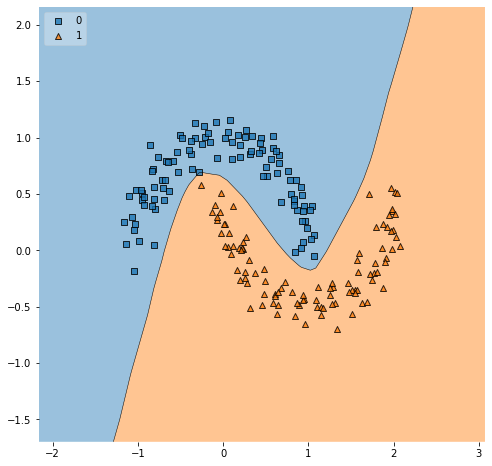

In [76]:
plot_decision_regions(X=X, y=y, clf=model, legend=2)

#### Pytorch 

References
* https://pytorch.org/docs/stable/generated/torch.nn.Module.html
* https://medium.com/biaslyai/pytorch-linear-and-logistic-regression-models-5c5f0da2cb9
* https://medium.com/biaslyai/pytorch-introduction-to-neural-network-feedforward-neural-network-model-e7231cff47cb
* https://towardsdatascience.com/building-neural-network-using-pytorch-84f6e75f9a

Need to rerun Pytorch data prep part first!

**Define Training Procedure**

In [45]:
def train_batch(model, train_iter, features, labels, loss, num_epochs, optimizer):
    """When training for a mini-batch."""
    for epoch in range(num_epochs):
        for X, y in train_iter:
            pred_y = model(X.float())
            l = loss(pred_y.squeeze(), y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        l = loss(model(features.float()).squeeze(), labels.float())
        print(f'epoch {epoch + 1}, loss {l:f}')

In [46]:
def train_epoch(model, X, y, loss, num_epochs, optimizer):
    """When training for an epoch."""
    for epoch in range(num_epochs):
        pred_y = model(X.float())
        l = loss(pred_y.squeeze(), y.float())
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        print(f'epoch {epoch + 1}, loss {l:f}')

**Define Decision Boundary Visualisation function**

In [47]:
def plot_decision_boundary(dataset, labels, model, steps=1000, color_map='Paired'):
    """Decision boundary function to classification models in Pytorch."""
    color_map = plt.get_cmap(color_map)
    # Define region of interest by data limits
    xmin, xmax = dataset[:, 0].min() - 1, dataset[:, 0].max() + 1
    ymin, ymax = dataset[:, 1].min() - 1, dataset[:, 1].max() + 1
    steps = 1000
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    # Make predictions across region of interest
    model.eval()
    labels_predicted = model(Variable(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()))

    # Plot decision boundary in region of interest
    labels_predicted = [0 if value <= 0.5 else 1 for value in labels_predicted.detach().numpy()]
    z = np.array(labels_predicted).reshape(xx.shape)
    
    fig, ax = plt.subplots()
    ax.contourf(xx, yy, z, cmap=color_map, alpha=0.5)

    # Get predicted labels on training data and plot
    train_labels_predicted = model(dataset)
    ax.scatter(dataset[:, 0], dataset[:, 1], c=labels.reshape(labels.size()[0]), cmap=color_map, lw=0)
    plt.show()
    return fig, ax

**Define Architecture**

In [48]:
class Feedforward(nn.Module):
    
    def __init__(self, input_size, h1_size, h2_size):

        super(Feedforward, self).__init__()
        self.input_size = input_size
        self.h1_size  = h1_size
        self.h2_size = h2_size

        self.fc1 = nn.Linear(self.input_size, self.h1_size)
        # self.relu = nn.ReLU()
        self.fc2 = nn.Linear(self.h1_size, self.h2_size)
        self.fc3 = nn.Linear(self.h2_size, 1)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))

        return x

In [49]:
# class Feedforward(torch.nn.Module):
    
#         def __init__(self, input_size, hidden_sizes, output_size):
            
#             super(Feedforward, self).__init__()
#             self.input_size = input_size
#             self.output_size = output_size
#             self.hidden_sizes  = hidden_sizes
            
#             # self.fc1 = torch.nn.Linear(self.input_size, self.hidden_sizes[0])
#             self.hidden = nn.ModuleList()
#             self.hidden.append(torch.nn.Linear(self.input_size, self.hidden_sizes[0]))
#             for k in range(len(self.hidden_sizes)-1):
#                 self.hidden.append(nn.Linear(self.hidden_sizes[k], self.hidden_sizes[k+1]))
#             self.hidden.append(nn.Linear(self.hidden_sizes[-1], self.output_size))
            
#         def forward(self, x):

#             self.last_fc = self.hidden.pop()
#             for fc in self.hidden:
#                 x = nn.functional.relu(fc(x))
#             # last layer is sigmoid for binary classification
#             x = torch.sigmoid(self.last_fc(x))
            
#             return x

In [50]:
# def init_weights(m):
#     if type(m) == nn.Linear:
#         nn.init.normal_(m.weight, std=INIT_STDDEV)

# model.apply(init_weights)

**Instantiate Model**

In [51]:
model = Feedforward(2, 32, 32)
model

Feedforward(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

**Define Loss and Optimiser**

In [52]:
loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

**Train Model**

In [53]:
train_batch(model, data_iter, features, labels, loss, NUM_EPOCHS, optimizer)

epoch 1, loss 0.616888
epoch 2, loss 0.569341
epoch 3, loss 0.563869
epoch 4, loss 0.557836
epoch 5, loss 0.554247
epoch 6, loss 0.552556
epoch 7, loss 0.551186
epoch 8, loss 0.547574
epoch 9, loss 0.558407
epoch 10, loss 0.551075
epoch 11, loss 0.534509
epoch 12, loss 0.536126
epoch 13, loss 0.535063
epoch 14, loss 0.531642
epoch 15, loss 0.530013
epoch 16, loss 0.529116
epoch 17, loss 0.542693
epoch 18, loss 0.531087
epoch 19, loss 0.522432
epoch 20, loss 0.517151


**MLP Decision Boundary**

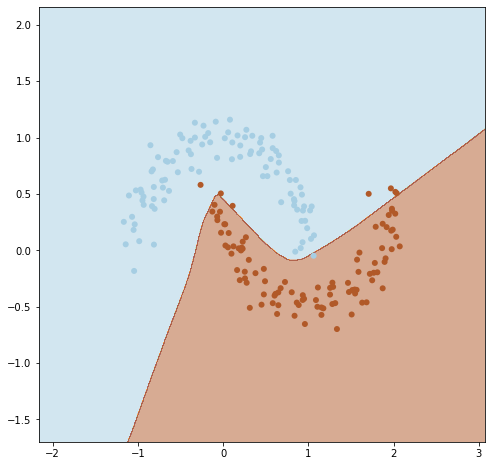

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [54]:
plot_decision_boundary(features.float(), labels.float(), model)

**Define Architecture 2**

In [82]:
input_size = 2
hidden_sizes = (32, 32)
output_size = 1

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Sigmoid()
                      )

# from collections import OrderedDict
# model = nn.Sequential(OrderedDict([('fc1', nn.Linear(input_size, hidden_sizes[0])),
#                                    ('act1', nn.Tanh()),
#                                    ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
#                                    ('act2', nn.Tanh()),
#                                    ('fc3', nn.Linear(hidden_sizes[1], output_size)),
#                                    ('out', nn.Sigmoid())
#                                    ]))

model

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
  (5): Sigmoid()
)

In [83]:
loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [84]:
train_batch(model, data_iter, features, labels, loss, NUM_EPOCHS, optimizer)

epoch 1, loss 0.612297
epoch 2, loss 0.572404
epoch 3, loss 0.567920
epoch 4, loss 0.588220
epoch 5, loss 0.571584
epoch 6, loss 0.563025
epoch 7, loss 0.556574
epoch 8, loss 0.559106
epoch 9, loss 0.550141
epoch 10, loss 0.550722
epoch 11, loss 0.548552
epoch 12, loss 0.547866
epoch 13, loss 0.545330
epoch 14, loss 0.542410
epoch 15, loss 0.538525
epoch 16, loss 0.540786
epoch 17, loss 0.534482
epoch 18, loss 0.532407
epoch 19, loss 0.529086
epoch 20, loss 0.525578


In [85]:
# train_epoch(model, features, labels, loss, NUM_EPOCHS, optimizer)

**MLP Decision Boundary**

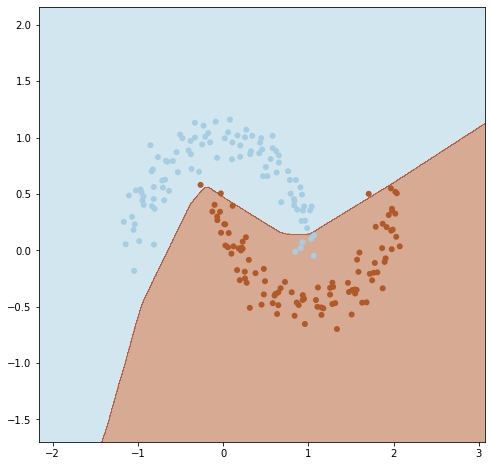

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [86]:
plot_decision_boundary(features.float(), labels.float(), model)